In [1]:
import pandas as pd
pd.options.display.max_rows = 999

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

# 1. Get the dataset

In [2]:
try:
    raw_df = pd.read_json("dataset.json")
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: 'dataset.json' not found. Please download it and place it in the correct directory.")

print("\n--- Data Info ---")
raw_df.info()

print("\n--- First 5 Rows ---")
print(raw_df.head())

print(f"\nDataset shape: {raw_df.shape}")

Dataset loaded successfully.

--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4040 entries, 0 to 4039
Data columns (total 32 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   giver_username_if_known                               4040 non-null   object 
 1   number_of_downvotes_of_request_at_retrieval           4040 non-null   int64  
 2   number_of_upvotes_of_request_at_retrieval             4040 non-null   int64  
 3   post_was_edited                                       4040 non-null   int64  
 4   request_id                                            4040 non-null   object 
 5   request_number_of_comments_at_retrieval               4040 non-null   int64  
 6   request_text                                          4040 non-null   object 
 7   request_text_edit_aware                               4040 non-null   object 
 8   request_ti

# 2. Clean the dataset

In [3]:
df = raw_df.copy()

# We don't use unix_timestamp_of_request because it uses incorrect timezone according to the dataset description.
df["request_datetime_utc"] = pd.to_datetime(
    df["unix_timestamp_of_request_utc"], unit="s"
)
# We can drop the original unix columns as they are now redundant
df.drop(
    ["unix_timestamp_of_request", "unix_timestamp_of_request_utc"], axis=1, inplace=True
)
# Redundant with request_text_edit_aware that is cleaned.
df.drop(
    "request_text",axis=1, inplace=True         
)
# Why: The column 'giver_username_if_known' uses the string 'N/A' for missing values.
# Standardizing this to NumPy's `np.nan` makes it easier to work with pandas'
# built-in functions for handling missing data (e.g., .isnull(), .fillna()).
# The same applies to `requester_user_flair` which has string 'None'.
df["giver_username_if_known"].replace("N/A", np.nan, inplace=True)
df["requester_user_flair"].replace("None", np.nan, inplace=True)

num_duplicates = df.duplicated(subset=["request_id"]).sum()
if num_duplicates > 0:
    print(f"Found {num_duplicates} duplicate requests. Removing them.")
    df.drop_duplicates(subset=["request_id"], keep="first", inplace=True)
else:
    print("No duplicate requests found based on 'request_id'.")

No duplicate requests found based on 'request_id'.


# 3. Statistics

### a. What is the prevalence for a requester to be given a pizza?

In [4]:
# Prevalence of receiving a pizza
prevalence = df['requester_received_pizza'].mean()
print(f"\nPrevalence of receiving a pizza: {prevalence:.2%}")
print(f"This means that about 1 in {1/prevalence:.1f} requests were successful.")


Prevalence of receiving a pizza: 24.60%
This means that about 1 in 4.1 requests were successful.


### b. What are the top 10 subreddits the requesters have already posted in the most?



--- Top 10 Subreddits by Requester Activity ---
requester_subreddits_at_request
AskReddit               2307
pics                    1949
funny                   1932
WTF                     1515
IAmA                    1507
gaming                  1485
Random_Acts_Of_Pizza    1413
videos                  1160
todayilearned           1103
AdviceAnimals           1021
Name: count, dtype: int64


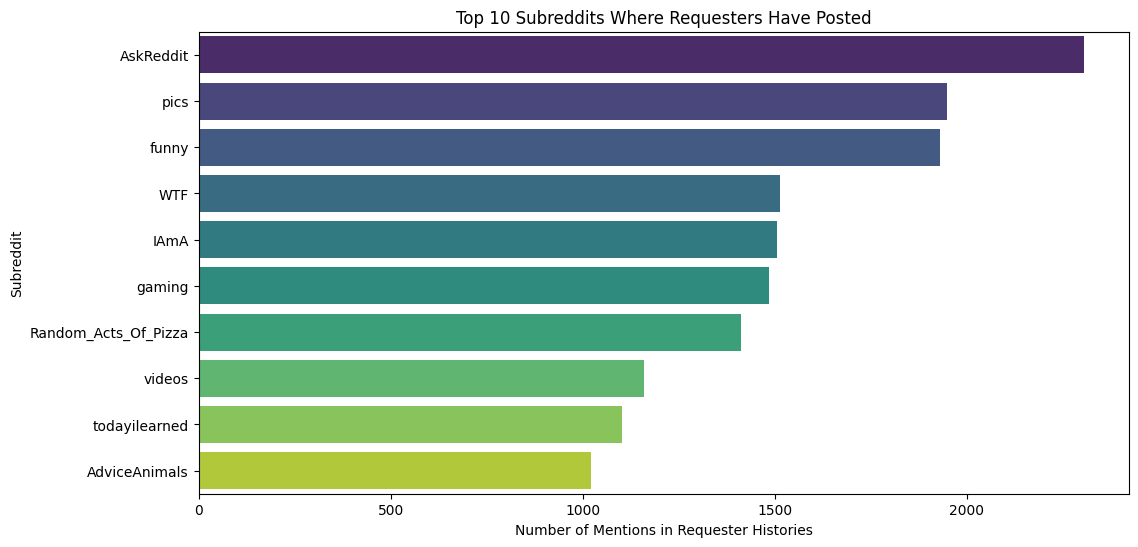

In [5]:
# Explode the requester_subreddits_at_request column then count and retrieve the top 10 subreddits
top_10_subreddits = (
    df["requester_subreddits_at_request"]
    .explode()
    .value_counts()
    .head(10)
)


print("\n--- Top 10 Subreddits by Requester Activity ---")
print(top_10_subreddits)

# Visualize the result
plt.figure(figsize=(12, 6))
sns.barplot(x=top_10_subreddits.values, y=top_10_subreddits.index, palette='viridis',hue=top_10_subreddits.index)
plt.title('Top 10 Subreddits Where Requesters Have Posted')
plt.xlabel('Number of Mentions in Requester Histories')
plt.ylabel('Subreddit')
plt.show()

### c. For each of these top 10 subreddits and for each month of data, how many of their active users requested a pizza in the past 6 months?

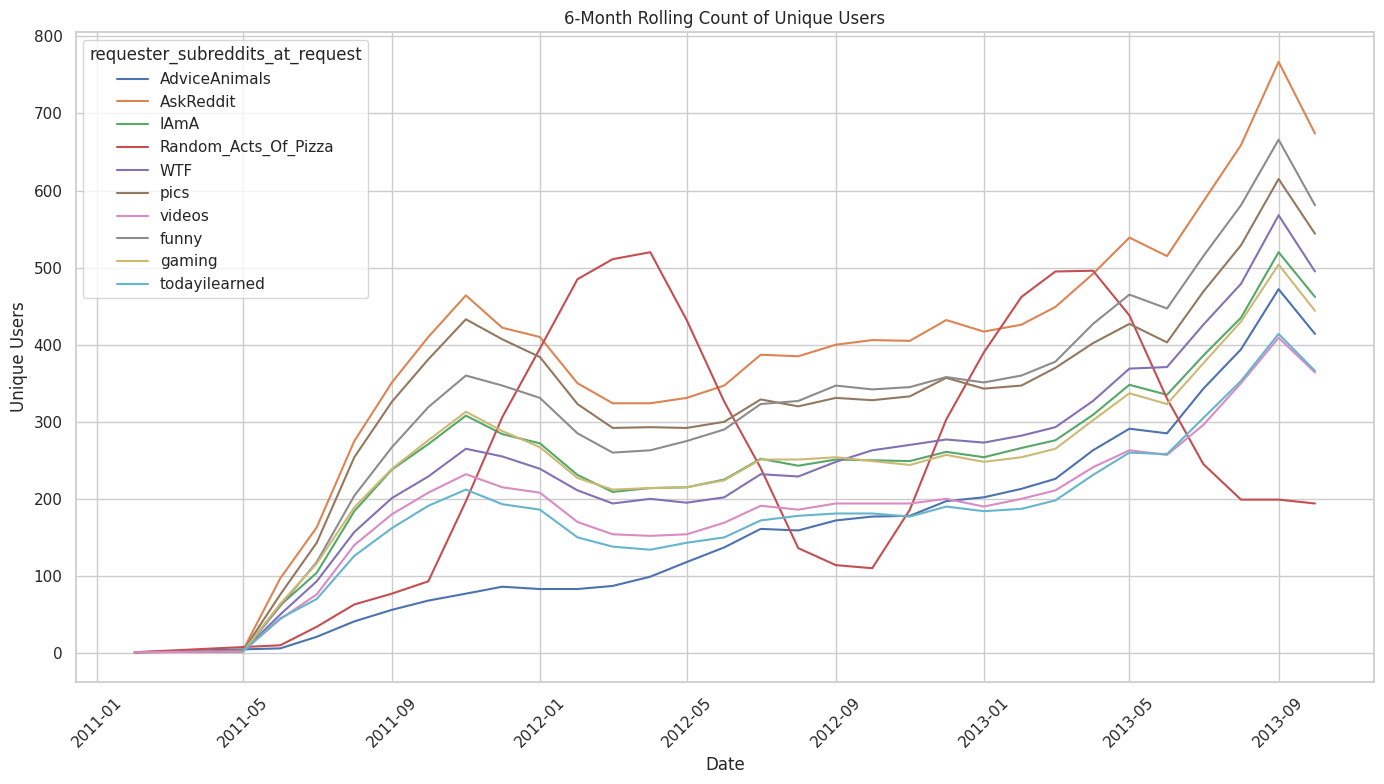

In [6]:
top_10_subreddits_list = top_10_subreddits.index.tolist()
# We explode the 'requester_subreddits_at_request', ie 1 row [['subreddit1', 'subreddit2']] ->  2 rows ['subreddit1', 'subreddit2']
df_clean_exploded = df.explode("requester_subreddits_at_request")
# We filter the DataFrame to only include rows where the subreddit is in the top 10
df_top_10_subreddits = df_clean_exploded[
    df_clean_exploded["requester_subreddits_at_request"].isin(top_10_subreddits_list)
].copy()
# New column for the year and month of the request
df_top_10_subreddits["year_month"] = df_top_10_subreddits[
    "request_datetime_utc"
].dt.to_period("M")

# We get the unique usernames list for each subreddit and month
active_user_month_sub = df_top_10_subreddits.groupby(
    ["year_month", "requester_subreddits_at_request"]
)["requester_username"].unique()

# First I tried using .rolling() but it seems to be only fitted for numeric data. 
# "DataError: No numeric types to aggregate"
# So instead we are doing the rolling unique count manually.

def calculate_rolling_unique_count(series_of_lists):
    rolling_counts = []
    for i in range(len(series_of_lists)):
        start_index = max(0, i - 5)
        window = series_of_lists[start_index : i + 1]
        count = window.explode().nunique()
        rolling_counts.append(count)
    return pd.Series(rolling_counts, index=series_of_lists.index)

final_result = active_user_month_sub.groupby(
    "requester_subreddits_at_request",
     group_keys=False       
).apply(
    calculate_rolling_unique_count
)

# Convert the Series with its MultiIndex into a cleaner DataFrame, reset_index() turns the index levels into columns, 'name' gives the data column a name.
final_result = final_result.reset_index(name="rolling_count")
# 3 cols 'year_month', 'requester_subreddits_at_request', 'rolling_count'

def plot_rolling_data(df_plot):
    # Convert the 'year_month' Period objects into Timestamps for better plotting.
    df_plot["year_month"] = df_plot["year_month"].dt.to_timestamp()

    plt.figure(figsize=(14, 8))
    sns.set_theme(style="whitegrid")

    sns.lineplot(
        data=df_plot,
        x="year_month",
        y="rolling_count",
        hue="requester_subreddits_at_request",
    )

    plt.title("6-Month Rolling Count of Unique Users")
    plt.ylabel("Unique Users")
    plt.xlabel("Date")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_rolling_data(final_result)

### d. What is the average time between two consecutive requests for each month, only for months with at least 50 requests?


In [7]:
df_analysed = df.copy()
df_analysed["year_month"] = df_analysed["request_datetime_utc"].dt.to_period("M")
df_analysed.sort_values(by="request_datetime_utc", inplace=True)
# Calculate the time difference between requests
df_analysed["time_between_requests"] = df_analysed["request_datetime_utc"].diff()


In [8]:
# This single chain combines the filtering and aggregation
average_time_per_month = (
    df_analysed.groupby("year_month")
    .filter(
        lambda group: len(group) >= 50
    )  # This keeps only the groups that have 50+ rows
    .groupby("year_month")[
        "time_between_requests"
    ]  # Now group again on the filtered data
    .mean()
)

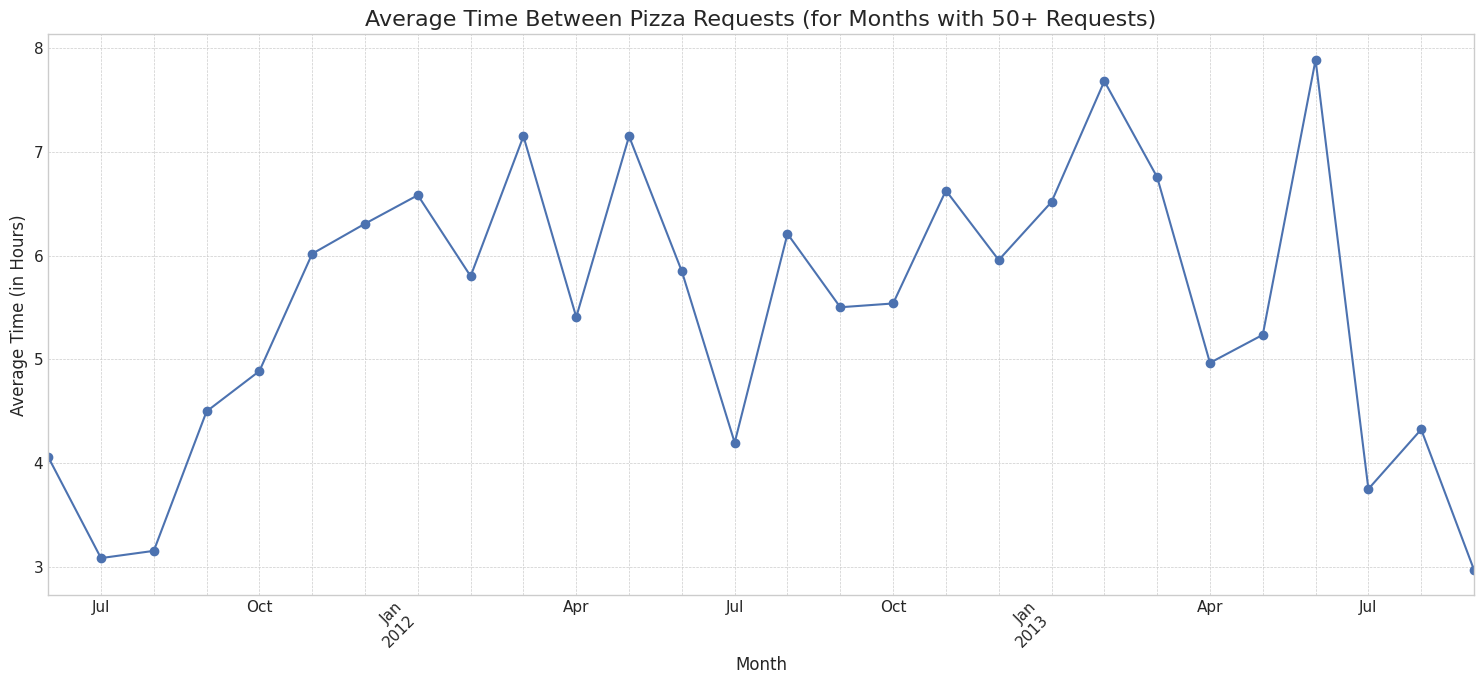

In [9]:
# Plotting
average_hours_per_month = average_time_per_month.dt.total_seconds() / 3600
# 1. The index is a PeriodIndex, convert it to string for cleaner labels
average_hours_per_month.index = average_hours_per_month.index.to_timestamp()
# 2. Create the plot
plt.style.use('seaborn-v0_8-whitegrid') # Makes the plot look nice
plt.figure(figsize=(15, 7)) # Make the plot larger for better readability

# Plot the data
average_hours_per_month.plot(kind='line', marker='o', linestyle='-')

# 3. Add titles and labels for clarity
plt.title('Average Time Between Pizza Requests (for Months with 50+ Requests)', fontsize=16)
plt.ylabel('Average Time (in Hours)', fontsize=12)
plt.xlabel('Month', fontsize=12)
# 4. Improve readability
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels to prevent overlap
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout() # Adjust layout to make sure everything fits

# 5. Show the plot
plt.show()

# 4. Preprocess the data for the task.

## Adressing Data Leakage

We choose to remove the column "_at_retrieval", to prevent data leakage. We want to predict "whether a requester will be given a pizza or not". Using information at retrieval is a little bit like cheating. We can suppose for instance that successfull request will be more upvoted by the community, "number_of_upvotes_of_request_at_retrieval" could give us the anwser.

In [20]:
df_clean = df.copy()
# We dont want to use any data that was collected after the request was made.
retrieval_cols = [col for col in df_clean.columns if "_at_retrieval" in col]
df_clean = df_clean.drop(columns=retrieval_cols)
print(f"Dropped {len(retrieval_cols)} data leakage columns.")
# We remove "requester_user_flair_at_retrieval" as it is assigned after the event. It's another direct leak.
df_clean = df_clean.drop(columns=["requester_user_flair"])
# We also remove "giver_username_if_known" You can only know this if the request was successful. This is a direct leak of the answer
df_clean = df_clean.drop(columns=["giver_username_if_known"])
df_clean.info()
# We also remove the 'post_was_edited' Because the edit often happens after the outcome is known, the post_was_edited flag contains information about the outcome.
df_clean = df_clean.drop(columns=["post_was_edited"])

# save the dataset as cleaned_dataset.json
df_clean.to_json("cleaned_dataset.json")

Dropped 11 data leakage columns.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4040 entries, 0 to 4039
Data columns (total 17 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   post_was_edited                                     4040 non-null   int64         
 1   request_id                                          4040 non-null   object        
 2   request_text_edit_aware                             4040 non-null   object        
 3   request_title                                       4040 non-null   object        
 4   requester_account_age_in_days_at_request            4040 non-null   float64       
 5   requester_days_since_first_post_on_raop_at_request  4040 non-null   float64       
 6   requester_number_of_comments_at_request             4040 non-null   int64         
 7   requester_number_of_comments_in_raop_at_request     4040 non-nu

## Feature Selection

In [31]:
y = df_clean['requester_received_pizza']
X = df_clean.drop(columns=['requester_received_pizza'])


In [32]:
from feature_engineering import create_features_for_model
create_features_for_model(X)

KeyError: 'unix_timestamp_of_request_utc'

## Feature Engineering

In [27]:
# Length of Request: A very long, detailed request might be more convincing than a short one.    
X['request_length'] = X['request_text_edit_aware'].str.len()

#Time of Day: Maybe requests made around dinner time are more likely to be fulfilled.      
X['hour_of_request'] = X['request_datetime_utc'].dt.hour
# Day of the Week: A "Friday pizza night" request might have a different success rate.
X['day_of_week'] = X['request_datetime_utc'].dt.dayofweek # Monday=0, Sunday=6
# Is this account only created for RAOP? Or is it a long-time user?
X['raop_post_ratio'] = X['requester_number_of_posts_on_raop_at_request'] / (X['requester_number_of_posts_at_request'] + 1e-6)
# Combine the two text columns into one.
X['full_request_text'] = X['request_title'].fillna('') + ' ' + X['request_text_edit_aware'].fillna('') + X["requester_username"].fillna('')

# --- 2. Identify columns to drop ---
columns_to_drop = [
    # These have been combined into 'full_request_text'
    'request_title',
    'request_text_edit_aware',
    'requester_username',
    # These are identifiers or raw data we've already used for feature engineering
    'request_datetime_utc',
    
    #request_id, model can't learn a pattern from request_id
    "request_id", 
    # We already have 'requester_number_of_subreddits_at_request' which captures some of this info.
    "requester_subreddits_at_request",  # This is a list of strings, hard to encode directly.
]

# Drop the columns
X_final = X.drop(columns=columns_to_drop)

print("--- Final columns for the model ---")
print(X.columns)
# print columns and their types
print("\n--- Feature Columns and Types ---")
print(X.dtypes)


--- Final columns for the model ---
Index(['request_id', 'request_text_edit_aware', 'request_title',
       'requester_account_age_in_days_at_request',
       'requester_days_since_first_post_on_raop_at_request',
       'requester_number_of_comments_at_request',
       'requester_number_of_comments_in_raop_at_request',
       'requester_number_of_posts_at_request',
       'requester_number_of_posts_on_raop_at_request',
       'requester_number_of_subreddits_at_request',
       'requester_subreddits_at_request',
       'requester_upvotes_minus_downvotes_at_request',
       'requester_upvotes_plus_downvotes_at_request', 'requester_username',
       'request_datetime_utc', 'request_length', 'hour_of_request',
       'day_of_week', 'raop_post_ratio', 'full_request_text'],
      dtype='object')

--- Feature Columns and Types ---
request_id                                                    object
request_text_edit_aware                                       object
request_title             

In [28]:
# Lists of column names based on your refined DataFrame
numeric_features = [
    'requester_account_age_in_days_at_request',
    'requester_days_since_first_post_on_raop_at_request',
    'requester_number_of_comments_at_request',
    'requester_number_of_comments_in_raop_at_request',
    'requester_number_of_posts_at_request',
    'requester_number_of_posts_on_raop_at_request',
    'requester_number_of_subreddits_at_request',
    'requester_upvotes_minus_downvotes_at_request',
    'requester_upvotes_plus_downvotes_at_request',
    'request_length',
    'raop_post_ratio'
]

categorical_features = [
    'hour_of_request',
    'day_of_week'
]

text_feature = 'full_request_text'

In [30]:
from feature_engineering import create_features_for_model
X = df_clean.drop(columns=["requester_received_pizza"])
X = create_features_for_model(X)

KeyError: 'unix_timestamp_of_request_utc'

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Create the individual transformer pipelines
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
text_transformer = Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=1000, stop_words='english'))]) # Increased max_features slightly

# Create the master preprocessor with ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('text', text_transformer, text_feature)
    ],
    remainder='drop' # Drop any columns that weren't specified
)

# --- Full Workflow Example ---
# Make sure y is defined (e.g., y = original_df['requester_received_pizza'])
# X_final is the DataFrame you created in Step 1

# Split data BEFORE any fitting
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42, stratify=y)

# Create the full model pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000)) # Increased max_iter for convergence
])

# Train the pipeline
model_pipeline.fit(X_train, y_train)

# Evaluate
score = model_pipeline.score(X_test, y_test)
print(f"\nModel accuracy on test set: {score:.4f}")


Model accuracy on test set: 0.7512


In [ ]:
print("Fitting the preprocessor on the training data...")
preprocessor.fit(X_train)

# Step 2: Transform both the training and test data
print("Transforming the train and test data...")
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"\nShape of processed training data: {X_train_processed.shape}")
print(f"Shape of processed test data: {X_test_processed.shape}")


# Step 3: Run FLAML on the pre-processed data
from flaml import AutoML

automl = AutoML()
settings = {
    "time_budget": 120,  # Run for 120 seconds
    "metric": 'roc_auc',
    "task": 'classification',
    "log_file_name": 'flaml_from_pipeline.log',
    "seed": 42
}

print("\nStarting FLAML search on the pre-processed data...")
# Note: We now feed the processed numpy arrays to FLAML
automl.fit(X_train=X_train_processed, y_train=y_train, **settings)
print("FLAML search complete.")

# Step 4: Evaluate the best model found by FLAML
print("\n--- FLAML Results ---")
print(f"Best model found: {automl.model.estimator}")
print(f"Best ROC AUC on validation data: {1 - automl.best_loss:.4f}")

# Evaluate the final model on the holdout processed test set
test_score = automl.score(X_test_processed, y_test)
print(f"\nROC AUC score on holdout test set: {test_score:.4f}")

Fitting the preprocessor on the training data...
Transforming the train and test data...

Shape of processed training data: (3232, 1031)
Shape of processed test data: (808, 1031)

Starting FLAML search on the pre-processed data...
[flaml.automl.logger: 06-23 13:11:44] {1752} INFO - task = classification
[flaml.automl.logger: 06-23 13:11:44] {1763} INFO - Evaluation method: holdout
[flaml.automl.logger: 06-23 13:11:44] {1862} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl.logger: 06-23 13:11:44] {1979} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'sgd', 'lrl1']
[flaml.automl.logger: 06-23 13:11:44] {2282} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 06-23 13:11:44] {2417} INFO - Estimated sufficient time budget=1266s. Estimated necessary time budget=29s.
[flaml.automl.logger: 06-23 13:11:44] {2466} INFO -  at 0.1s,	estimator lgbm's best error=0.4150,	best estimator lgbm's best error=0.4150
[flaml.automl.lo

In [ ]:
import joblib
from sklearn.pipeline import Pipeline

# 1. Retrieve the best model object from the completed FLAML run
best_flaml_model = automl.model.estimator

# 2. Create a final, complete pipeline
# This pipeline chains your preprocessor with the best model found by FLAML
final_model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', best_flaml_model)
])

# 3. Fit the final pipeline on the ENTIRE training dataset
# This retrains the best model on all available training data, making it slightly more robust.
print("Fitting the final pipeline on the entire training set...")
final_model_pipeline.fit(X_train, y_train)
print("Fitting complete.")

# 4. Save the final pipeline object to a file
model_filename = 'pizza_request_model.joblib'
print(f"Saving final model to {model_filename}...")
joblib.dump(final_model_pipeline, model_filename)
print("Model saved successfully.")

# You can now load this single file in your API to make predictions on new raw data.

Fitting the final pipeline on the entire training set...
Fitting complete.
Saving final model to pizza_request_model.joblib...
Model saved successfully.


In [ ]:
# Make sure you have your final feature DataFrame 'X_final' and target Series 'y' ready
# Also, your 'preprocessor' from the previous step must be defined.

# You might need to install lightgbm: pip install lightgbm
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier

# Create a dictionary of models to test
# The key is the model name, the value is the model instance
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Linear SVM': LinearSVC(random_state=42, dual=False), # dual=False is recommended when n_samples > n_features
    'Random Forest': RandomForestClassifier(random_state=42),
    'LightGBM': LGBMClassifier(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np
import pandas as pd

# We'll use Stratified K-Folds to ensure each fold has the same proportion of positive/negative classes as the whole dataset
# This is important for imbalanced datasets.
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Dictionary to store the results
results = {}

print("Starting model evaluation...")
for model_name, classifier in models.items():
    # Create the full pipeline by combining the preprocessor with the current classifier
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])

    # Perform cross-validation
    # We'll use 'roc_auc' as our primary scoring metric
    scores = cross_val_score(model_pipeline, X_final, y, cv=cv_strategy, scoring='roc_auc', n_jobs=-1)

    # Store the mean and standard deviation of the scores
    results[model_name] = {
        'mean_roc_auc': np.mean(scores),
        'std_roc_auc': np.std(scores)
    }

    print(f"  {model_name}: Mean ROC AUC = {np.mean(scores):.4f} (± {np.std(scores):.4f})")

print("Model evaluation complete.")

Starting model evaluation...
  Logistic Regression: Mean ROC AUC = 0.6283 (± 0.0181)
  Linear SVM: Mean ROC AUC = 0.5869 (± 0.0200)
  Random Forest: Mean ROC AUC = 0.6252 (± 0.0095)
[LightGBM] [Info] Number of positive: 795, number of negative: 2437
[LightGBM] [Info] Number of positive: 795, number of negative: 2437
[LightGBM] [Info] Number of positive: 795, number of negative: 2437
[LightGBM] [Info] Number of positive: 795, number of negative: 2437
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.318695 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29060
[LightGBM] [Info] Number of data points in the train set: 3232, number of used features: 923
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.245978 -> initscore=-1.120181
[LightGBM] [Info] Start training from score -1.120181
[LightGBM] [Info] Number of positive: 796, number of negat

/home/gauthier/code/cybel_test/.cybel_env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/gauthier/code/cybel_test/.cybel_env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/gauthier/code/cybel_test/.cybel_env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/gauthier/code/cybel_test/.cybel_env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/gauthier/code/cybel_test/.cybel_env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning

  LightGBM: Mean ROC AUC = 0.6250 (± 0.0154)
  K-Nearest Neighbors: Mean ROC AUC = 0.5662 (± 0.0300)
Model evaluation complete.


In [ ]:
# Convert the results dictionary to a DataFrame for easy viewing
results_df = pd.DataFrame(results).T # .T transposes the DataFrame to have models as rows

# Sort the DataFrame by the mean score to see the best models at the top
results_df = results_df.sort_values(by='mean_roc_auc', ascending=False)

print("\n--- Model Comparison ---")
print(results_df)


--- Model Comparison ---
                     mean_roc_auc  std_roc_auc
Logistic Regression      0.628334     0.018133
Random Forest            0.625218     0.009548
LightGBM                 0.624957     0.015405
Linear SVM               0.586915     0.020036
K-Nearest Neighbors      0.566205     0.029993


In [ ]:
from flaml import AutoML
from sklearn.model_selection import train_test_split

# Assume 'X_final' is your DataFrame with all engineered features
# Assume 'y' is your target Series ('requester_received_pizza')

# --- 1. Prepare the data for FLAML ---
# For this run, we will use all features EXCEPT the raw text column.
X_for_flaml = X_final.drop(columns=['full_request_text'])
y_for_flaml = y.copy() # Make a copy to be safe

# Split the data (FLAML can also do this, but manual split is fine)
X_train, X_test, y_train, y_test = train_test_split(
    X_for_flaml, y_for_flaml, test_size=0.2, random_state=42
)


# --- 2. Initialize and configure AutoML ---
automl = AutoML()

# Settings for the AutoML run
settings = {
    "time_budget": 120,  # Total time in seconds to find the best model
    "metric": 'roc_auc', # Metric to optimize for
    "task": 'classification', # Specify the task type
    "log_file_name": 'flaml_pizza.log', # Log file
    "seed": 42, # For reproducibility
}


# --- 3. Run the AutoML search ---
print("Starting FLAML search...")
automl.fit(X_train=X_train, y_train=y_train, **settings)
print("FLAML search complete.")


# --- 4. Review the results ---
print("\n--- FLAML Results ---")
print(f"Best model found: {automl.model.estimator}")
print(f"Best ROC AUC score on validation data: {1 - automl.best_loss:.4f}") # Loss is 1-score

# You can also see the full configuration of the best model
print("\n--- Best Model Configuration ---")
print(automl.best_config)

# Evaluate the final model on the holdout test set
test_score = automl.score(X_test, y_test)
print(f"\nROC AUC score on holdout test set: {test_score:.4f}")

Starting FLAML search...
[flaml.automl.logger: 06-23 13:01:09] {1752} INFO - task = classification
[flaml.automl.logger: 06-23 13:01:09] {1763} INFO - Evaluation method: cv
[flaml.automl.logger: 06-23 13:01:09] {1862} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl.logger: 06-23 13:01:09] {1979} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'sgd', 'lrl1']
[flaml.automl.logger: 06-23 13:01:09] {2282} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 06-23 13:01:09] {2417} INFO - Estimated sufficient time budget=1497s. Estimated necessary time budget=35s.
[flaml.automl.logger: 06-23 13:01:09] {2466} INFO -  at 0.2s,	estimator lgbm's best error=0.3864,	best estimator lgbm's best error=0.3864
[flaml.automl.logger: 06-23 13:01:09] {2282} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 06-23 13:01:09] {2466} INFO -  at 0.2s,	estimator lgbm's best error=0.3802,	best estimator lgbm's best error=0.3802
[fl